In [2]:
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")


import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import openmm
import pandas as pd
from mycolorpy import colorlist as mcp
from openff.toolkit import topology
from openff.units import unit
from rdkit import Chem
from rdkit.Chem import Draw
from scipy.stats import linregress
from tools import base, boxer, simulator
from tqdm import tqdm

from tools import simulator,base,boxer

In [ ]:
{}.

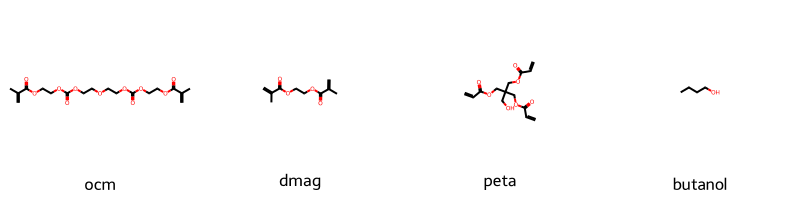

In [12]:
Draw.MolsToGridImage(
    list(base.RD_MOLECULES.values()),
    useSVG=True,
    molsPerRow=4,
    legends=[i.name for i in base.RD_MOLECULES.keys()])

# Collector

In [12]:
%matplotlib inline

In [36]:
def filter_df(df: pd.DataFrame, substance: base.MolNames) -> pd.DataFrame:
    but_time = df[df['BUT'] == df['BUT'].max()]['Time'].max()
    comp_time = df[df[substance.value] == df[substance.value].max()]['Time'].max()

    time_max = min(but_time, comp_time)
    # FIXME:
    time_min = 0
    time_max = 1e-5
    # time_max = 100*1e-12
    return df[(time_min <= df['Time']) & (df['Time'] <= time_max)]


def get_data(path: Path):
    substance, x, rho = path.stem.split('_')
    substance = base.MolNames(substance.upper()[:3])
    x = int(x)
    rho = int(rho)
    dfs = []
    for file in os.listdir(path):
        file=path/Path(file)
        T = int(file.stem)
        df = pd.read_csv(file, index_col=0)
        if 'BUT' not in df.columns:
            df['BUT'] = 0
        df = filter_df(df, substance)

        df['MSE substance'] = df[substance.value]
        df['MSE butanol'] = df['BUT']
        df['T'] = T
        dfs.append(df)

    df = pd.concat(dfs,ignore_index=True)
    df['substance'] = substance.value
    df['rho'] = rho
    df['x'] = x
    return df.drop(columns=[substance.value, 'BUT'])[[
        'Time','substance','T','x','rho','MSE substance','MSE butanol'
    ]]


def collect():
    dfs = []
    for current_dir in os.listdir('results'):
        dfs.append(get_data(Path(f'results/{current_dir}')))
    return pd.concat(dfs)


def get_D(time, mse):
    try:
        linear_model = linregress(time, mse)
        slope = linear_model.slope
        D_comp = slope / 6 * 24 * 60 * 60
    except:
        D_comp = 0
    return D_comp


def extract_D(df_all):
    data = []
    for (substance, x, T), df in df_all.groupby(by=['substance', 'x', 'T']):
        D_substance = get_D(df['Time'], df['MSE_substance'])
        D_butanol = get_D(df['Time'], df['MSE_butanol'])
        data.append(
            {
                'substance': substance,
                'x': x,
                'T': T,
                'D_substance': D_substance,
                'D_butanol': D_butanol,
            }
        )
    return pd.DataFrame(data)

In [42]:
DF = collect()

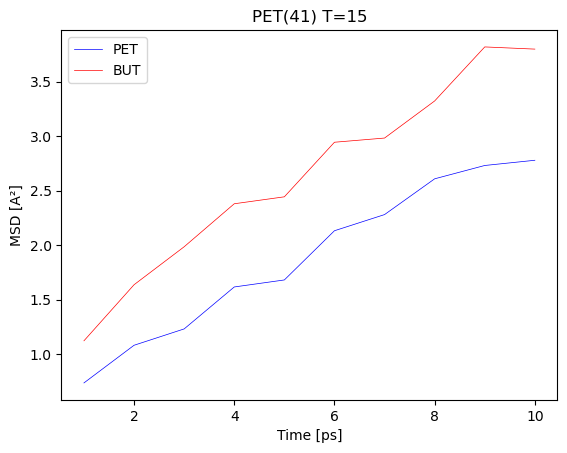

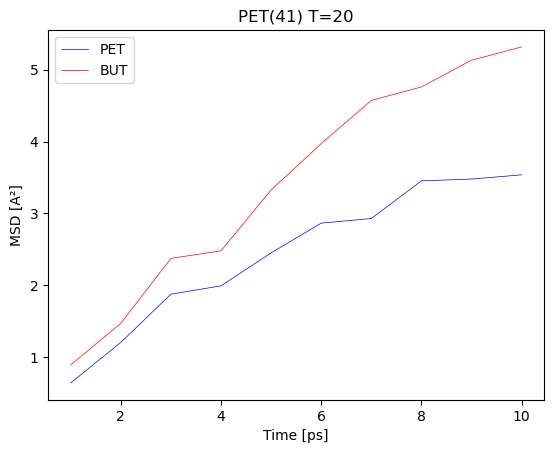

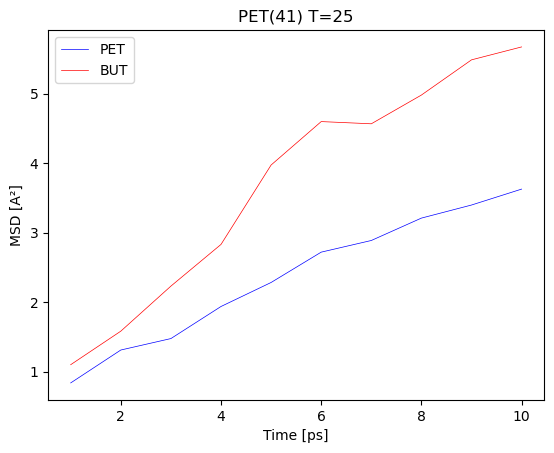

In [46]:
# MSE
color = 'black'
for mol in base.MolNames:
    for x in [i[0] for i in base.DATAS[mol]]:
        for T in [15, 20, 25, 30, 40]:
            df = DF[(DF['substance'] == mol.value) & (DF['x'] == x) & (DF['T'] == T)]
            if len(df) == 0:
                continue
            fig, ax = plt.subplots()

            ax.plot(
                df['Time'] * 10**12,
                df['MSE substance'] * 10**16,
                label=mol.value,
                linewidth=0.5,
                c='blue',
            )
            ax.plot(
                df['Time'] * 10**12,
                df['MSE butanol'] * 10**16,
                label='BUT',
                linewidth=0.5,
                c='red',
            )

            ax.set_title(f'{mol.value}({x}) {T=}')
            ax.set_xlabel('Time [ps]')
            ax.set_ylabel('MSD [A²]')
            ax.legend()
            plt.show()


In [56]:
DF_D = extract_D(DF)
DF_D

,substance,x,T,D_substance,D_butanol
0,BUT,100,15,0.666173,0.666173
1,BUT,100,20,0.624319,0.624319
2,BUT,100,25,0.752900,0.752900
3,BUT,100,30,0.729460,0.729460
4,BUT,100,40,1.278024,1.278024
...,...,...,...,...,...
64,PET,41,15,0.145825,0.143770
65,PET,41,20,0.032527,0.048084
66,PET,41,25,0.131071,0.158539
67,PET,41,30,0.167272,0.174952


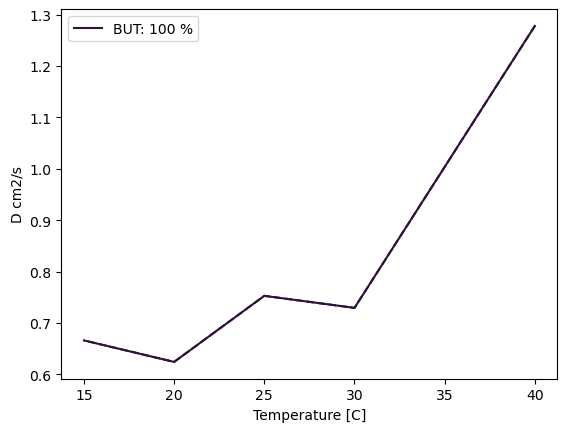

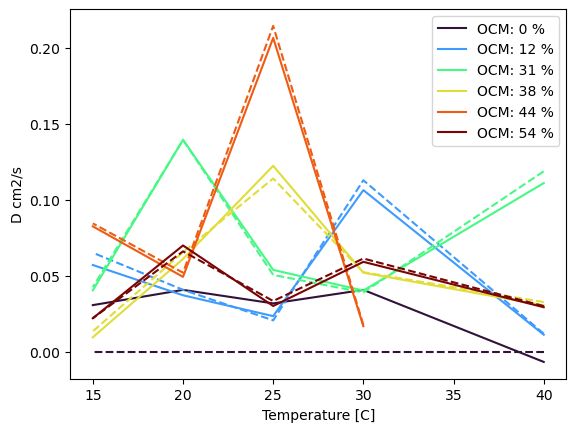

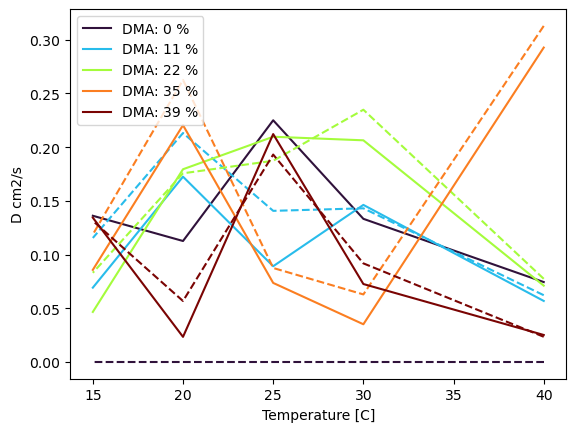

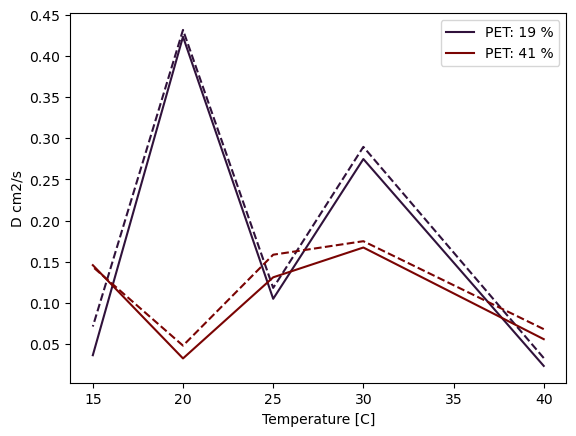

In [55]:
# D
for substance in base.MolNames:
    substance = substance.value
    df_sub = DF_D[DF_D['substance'] == substance]
    colors_list = mcp.gen_color(
        cmap="turbo",
        n=len(df_sub['x'].unique()),
    )
    fig, ax = plt.subplots(num="DT")
    i = 0
    for [x], df in df_sub.groupby(by=['x']):
        data_x = df.sort_values(by=['T'], ascending=False)
        ax.plot(
            data_x['T'],
            data_x['D_substance'],
            label=f"{substance}: {x} %",
            c=colors_list[i],
        )
        ax.plot(
            data_x['T'],
            data_x['D_butanol'],
            linestyle='dashed',
            c=colors_list[i],
        )
        i+=1
    ax.set_xlabel("Temperature [C]")
    ax.set_ylabel("D cm2/s")
    ax.legend()
    plt.show()